In [1]:
from __future__ import print_function
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from tensorboardX import SummaryWriter

from matplotlib import pyplot as plt

from tqdm import tqdm

batch_size = 128
epochs = 10000
seed = 1
torch.manual_seed(seed)

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
device = "cpu"

In [2]:
from Tars.distributions import CustomLikelihoodDistribution, Normal
from Tars.models import VI
from Tars.utils import get_dict_values

In [3]:
import torch
z_dim = 2

def likelihood(z):
    z1, z2 = torch.chunk(z, chunks=2, dim=1)
    norm = torch.sqrt(z1 ** 2 + z2 ** 2)

    exp1 = torch.exp(-0.5 * ((z1 - 2) / 0.6) ** 2)
    exp2 = torch.exp(-0.5 * ((z1 + 2) / 0.6) ** 2)
    u = 0.5 * ((norm - 2) / 0.4) ** 2 - torch.log(exp1 + exp2)

    return torch.exp(-u)

p = CustomLikelihoodDistribution(var=["z"], likelihood=likelihood)

loc = torch.tensor(0.).to(device)
scale = torch.tensor(1.).to(device)
_q = Normal(loc=loc, scale=scale, var=["z_0"], dim=z_dim)

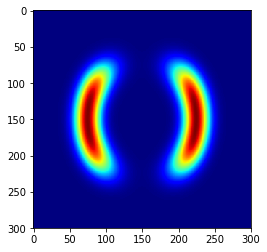

In [4]:
import numpy as np
def plot_density(p):

    X_LIMS = (-4, 4)
    Y_LIMS = (-4, 4)

    x1 = np.linspace(*X_LIMS, 300)
    x2 = np.linspace(*Y_LIMS, 300)
    x1, x2 = np.meshgrid(x1, x2)
    shape = x1.shape
    x1 = x1.ravel()
    x2 = x2.ravel()

    z = np.c_[x1, x2]
    z = torch.FloatTensor(z)

    density_values = torch.exp(p.log_likelihood({"z":z})).data.numpy().reshape(shape)
    plt.imshow(density_values, cmap='jet')
    plt.show()
    
plot_density(p)

In [5]:
from Tars.distributions import PlanarFlow
q = PlanarFlow(_q, z_dim, var=["z"], num_layers=32)

p.to(device)
q.to(device)

print(p.prob_text)
print(_q.prob_text)
print(q.prob_text)

p(z)
p(z_0)
PlanarFlow(z ; p(z_0))


In [6]:
model = VI(p, q, optim.Adam, {"lr":1e-3})

In [8]:
for epoch in range(epochs):
    lower_bound, loss = model.train(batch_size=batch_size)
    if epoch % 500 == 0:
        lower_bound, loss = model.test(batch_size=batch_size)
        print('Epoch: {} Test loss: {:.4f}'.format(epoch, loss))

Epoch: 0 Test loss: 7.0613
Epoch: 500 Test loss: -1.1443
Epoch: 1000 Test loss: -1.1959
Epoch: 1500 Test loss: -1.1673
Epoch: 2000 Test loss: -1.1597
Epoch: 2500 Test loss: -1.1817
Epoch: 3000 Test loss: -1.1829
Epoch: 3500 Test loss: -1.1619
Epoch: 4000 Test loss: -1.1723
Epoch: 4500 Test loss: -1.1907
Epoch: 5000 Test loss: -1.2044
Epoch: 5500 Test loss: -1.2569
Epoch: 6000 Test loss: -1.5158
Epoch: 6500 Test loss: -1.7667
Epoch: 7000 Test loss: -1.8030
Epoch: 7500 Test loss: -1.8236
Epoch: 8000 Test loss: -1.8588
Epoch: 8500 Test loss: -1.8654
Epoch: 9000 Test loss: -1.8373
Epoch: 9500 Test loss: -1.8354


In [9]:
def plot_samples(points):
    X_LIMS = (-4, 4)
    Y_LIMS = (-4, 4)

    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(111)
    ax.scatter(points[:, 0], points[:, 1], alpha=0.7, s=25)
    ax.set_xlim(*X_LIMS)
    ax.set_ylim(*Y_LIMS)

    plt.show()

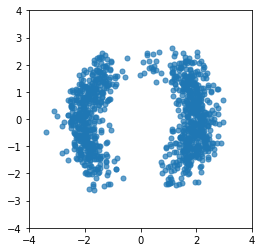

In [10]:
samples = q.sample(batch_size=1000)
plot_samples(samples["z"].cpu().data.numpy())